In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMAResults 
from sklearn.metrics import mean_squared_error
import pandas as pd
import warnings
import itertools
from sklearn.model_selection import TimeSeriesSplit
import statsmodels
import statsmodels.api as sm
import itertools
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.
C:\Users\gleny\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\gleny\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\gleny\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\gleny\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [9]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [50]:
# load dataset
dataset = pd.read_csv('convertcsv.csv', header=0, index_col=0)
dataset = dataset.drop(['Date', 'Date.1', 'Date.2'], axis=1)
values = dataset.values
# integer encode direction
# encoder = LabelEncoder()
# values[:, 4] = encoder.fit_transform(values[:, 4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
days = 20
features = 49
reframed = series_to_supervised(scaled, days, 1)
reframe_f_arima = series_to_supervised(scaled, days, 1)
# drop columns we don't want to predict
# reframed.drop(reframed.columns.to_series()[51:100], axis=1, inplace=True)
print("reframe")
#print(reframed)
np.random.shuffle(reframed.values)
# split into train and test sets
values = reframed.values
n_train_hours = 1727  # 0.9*1938 (1919????)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
obs = days * features
train_X, train_y = train[:, :obs], train[:, -features]
test_X, test_y = test[:, :obs], test[:, -features]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], days, features))
test_X = test_X.reshape((test_X.shape[0], days, features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


reframe
(1727, 20, 49) (1727,) (192, 20, 49) (192,)


In [51]:
values_f_arima = reframe_f_arima.values
train_f_arima = values_f_arima[:n_train_hours, :]
test_f_arima = values_f_arima[n_train_hours:, :]

train_X_f_arima, train_y_f_arima = train_f_arima[:, :obs], train_f_arima[:, -features]
test_X_f_arima, test_y_f_arima = test_f_arima[:, :obs], test_f_arima[:, -features]
# reshape input to be 3D [samples, timesteps, features]
train_X_f_arima = train_X_f_arima.reshape((train_X_f_arima.shape[0], days, features))
test_X_f_arima = test_X_f_arima.reshape((test_X_f_arima.shape[0], days, features))
print(train_X_f_arima.shape, train_y_f_arima.shape, test_X_f_arima.shape, test_y_f_arima.shape)

(1727, 20, 49) (1727,) (192, 20, 49) (192,)


In [38]:
train_y_f_arima

array([0.07138001, 0.04799456, 0.06594152, ..., 0.07369136, 0.12358937,
       0.09707683], dtype=float32)

In [35]:
reframe_f_arima

,var1(t-20),var2(t-20),var3(t-20),var4(t-20),var5(t-20),var6(t-20),var7(t-20),var8(t-20),var9(t-20),var10(t-20),...,var40(t),var41(t),var42(t),var43(t),var44(t),var45(t),var46(t),var47(t),var48(t),var49(t)
20,0.043100,0.064143,0.072355,0.089752,0.114126,0.159375,0.194680,0.210459,0.243281,0.852146,...,0.865672,0.929329,0.810496,0.842857,0.680147,0.516129,0.223754,0.556540,0.101462,0.175826
21,0.075323,0.088048,0.093313,0.110121,0.133280,0.180208,0.216445,0.230867,0.260255,0.812628,...,0.885572,0.908127,0.793003,0.771429,0.643382,0.516129,0.189879,0.549745,0.120760,0.093733
22,0.082665,0.089641,0.096307,0.115213,0.138069,0.186458,0.226119,0.238520,0.271570,0.792641,...,0.875622,0.922261,0.798834,0.814286,0.658088,0.506912,0.220942,0.558953,0.107602,0.104255
23,0.068389,0.079283,0.087325,0.107575,0.128492,0.176042,0.209190,0.225765,0.254597,0.810811,...,0.885572,0.915194,0.787172,0.785714,0.636029,0.497696,0.205856,0.551567,0.090643,0.052036
24,0.133922,0.123904,0.123254,0.135582,0.158819,0.201042,0.230955,0.241071,0.265912,0.719055,...,0.865672,0.915194,0.798834,0.814286,0.665441,0.516129,0.185833,0.547381,0.086550,0.103159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1934,0.234398,0.340239,0.431138,0.486314,0.553871,0.673958,0.740024,0.723214,0.759547,1.000000,...,0.751244,0.724382,0.548105,0.592857,0.433824,0.368664,0.392100,0.840326,0.391184,0.033097
1935,0.231815,0.333865,0.432136,0.476766,0.541101,0.662500,0.730351,0.709184,0.743989,0.990461,...,0.716418,0.692580,0.510204,0.578571,0.411765,0.350230,0.489063,0.841360,0.394854,0.084375
1936,0.232903,0.317131,0.414172,0.464672,0.531524,0.651042,0.711004,0.691327,0.721358,0.939132,...,0.726368,0.696113,0.495627,0.571429,0.386029,0.322581,0.504423,0.843527,0.383948,0.073651
1937,0.234262,0.326693,0.430140,0.476130,0.539505,0.663542,0.725514,0.706633,0.728430,0.961844,...,0.676617,0.621908,0.440233,0.492857,0.352941,0.331797,0.618871,0.817329,0.377866,0.153699


In [3]:
# # random seed
# np.random.seed(1111)

# # load the data
# path_to_dataset = 'convertcsv.csv'
# sequence_length = 20

# # vector to store the time series
# vector_vix = []
# with open(path_to_dataset) as f:
#     next(f) # skip the header row
#     for line in f:
#         fields = line.split(',')
#         vector_vix.append(float(fields[52]))

# # convert the vector to a 2D matrix
# matrix_vix = convertSeriesToMatrix(vector_vix, sequence_length)
# matrix_vix = np.array(matrix_vix)

# matrix_vix

array([[12.31, 14.68, 15.22, ..., 11.3 , 11.3 , 13.36],
       [14.68, 15.22, 14.17, ..., 11.3 , 13.36, 14.39],
       [15.22, 14.17, 18.99, ..., 13.36, 14.39, 12.67],
       ...,
       [26.37, 26.7 , 27.63, ..., 27.55, 32.46, 33.35],
       [26.7 , 27.63, 27.96, ..., 32.46, 33.35, 40.28],
       [27.63, 27.96, 29.48, ..., 33.35, 40.28, 37.59]])

In [42]:
# #remove this 2 !!!!!!!!!!!!!
# #shifted_value = matrix_vix.mean()
# #matrix_vix -= shifted_value

# train_row = int(round(0.85 * matrix_vix.shape[0]))
# train_set = matrix_vix[:train_row, :]

# # shuffle the training set (but do not shuffle the test set)
# #np.random.shuffle(train_set)

# # the training set
# X_train = train_set[:, :-1]
# # the last column is the true value to compute the mean-squared-error loss
# Y_train = train_set[:, -1]
# # the test set
# X_test = matrix_vix[train_row:, :-1]
# Y_test = matrix_vix[train_row:, -1]

# # the input to LSTM layer needs to have the shape of (number of samples, the dimension of each element)
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

TimeSeriesSplit(max_train_size=None, n_splits=4)
TRAIN: [0 1 2 3 4] TEST: [5]
TRAIN: [0 1 2 3 4 5] TEST: [6]
TRAIN: [0 1 2 3 4 5 6] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7] TEST: [8]


In [52]:
# build the model
model = Sequential()
# layer 1: LSTM
model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
# layer 2: LSTM
model.add(LSTM(256, return_sequences=False))
model.add(Dropout(0.2))
# layer 3: dense
# linear activation: a(x) = x
model.add(Dense(units=1))
model.add(Activation('sigmoid'))
# compile the model
model.compile(loss="mse", optimizer="adam")
print(model.summary())

history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2)
# evaluate the result
test_mse = model.evaluate(test_X, test_y, verbose=1)
print ('\nThe mean squared error (MSE) on the test data set is %.3f over %d test samples.' % (test_mse, len(test_y)))


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 20, 128)           91136     
_________________________________________________________________
dropout_5 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 256)               394240    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 485,633
Trainable params: 485,633
Non-trainable params: 0
________________________________________________

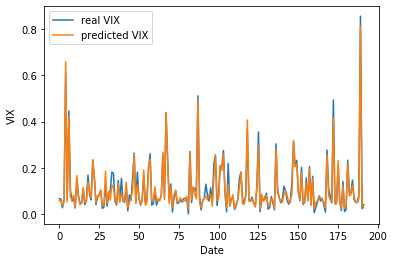

In [53]:



# # build the model
# model = Sequential()
# # layer 1: LSTM
# model.add(LSTM(units=100, input_shape=(19, 1), return_sequences=True))
# model.add(Dropout(0.2))
# # layer 2: LSTM
# model.add(LSTM(100, return_sequences=False))
# model.add(Dropout(0.2))
# # layer 3: dense
# # linear activation: a(x) = x
# model.add(Dense(units=1))
# model.add(Activation('linear'))
# # compile the model
# model.compile(loss="mse", optimizer="rmsprop")
# print(model.summary())


# # train the model
# model.fit(X_train, Y_train, batch_size=512, epochs=50, validation_split=0.05, verbose=1)


# # evaluate the result
# test_mse = model.evaluate(X_test, Y_test, verbose=1)
# print ('\nThe mean squared error (MSE) on the test data set is %.3f over %d test samples.' % (test_mse, len(Y_test)))

# get the predicted values
predicted_values = model.predict(test_X)
num_test_samples = len(predicted_values)
predicted_values = np.reshape(predicted_values, (num_test_samples,1))
test_y = test_y.reshape(test_y.shape[0],1)



# plot the results (LSTM ONLY)
fig = plt.figure()
plt.plot(test_y, label='real VIX')
plt.plot(model.predict(test_X), label='predicted VIX')
plt.xlabel('Date')
plt.ylabel('VIX')
plt.legend()
plt.show()
fig.savefig('output_prediction.jpg', bbox_inches='tight')

# save the result into txt file
#test_result = list(zip(predicted_values, Y_test)) + shifted_value
#np.savetxt('output_result.txt', test_result)



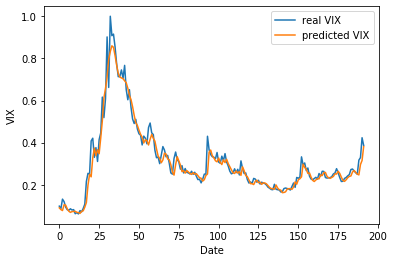

In [54]:


predicted_values_f_arima = model.predict(test_X_f_arima)
num_test_samples = len(predicted_values_f_arima)
predicted_values_f_arima = np.reshape(predicted_values, (num_test_samples,1))
test_y_f_arima = test_y_f_arima.reshape(test_y_f_arima.shape[0],1)



# plot the results (LSTM ONLY)
fig = plt.figure()
plt.plot(test_y_f_arima, label='real VIX')
plt.plot(model.predict(test_X_f_arima), label='predicted VIX')
plt.xlabel('Date')
plt.ylabel('VIX')
plt.legend()
plt.show()
fig.savefig('output_prediction.jpg', bbox_inches='tight')

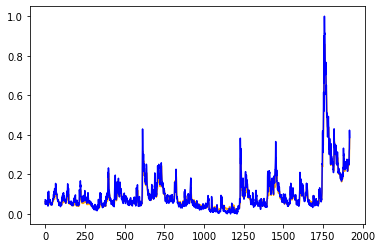

In [55]:
all_data = values_f_arima[:, :]
# split into input and outputs
obs = days * features
all_X, all_y = all_data[:, :obs], all_data[:, -features]

# reshape input to be 3D [samples, timesteps, features]
all_X = all_X.reshape((all_X.shape[0], days, features))
all_y = all_y.reshape((all_y.shape[0], 1))

pred_y = model.predict(all_X)

plt.plot(pred_y, color='orange')
plt.plot(all_y, color='blue')

In [56]:
divi_for_training = all_y - pred_y

In [58]:
max(divi_for_training)

array([0.29564467], dtype=float32)

In [59]:
# dynamic arima trainig

def evaluate_arima_model(residual):
    # prepare training dataset
    train_size = int(len(residual) * 0.9)
    train = residual[0:train_size]
    test = residual[train_size:]
    
    history = [x for x in train]
    # make predictions
    predictions = list()
    
    for t in range(len(test)):
        
        model = ARIMA(history, order=(1,0,0))
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
        
    plt.plot(predictions, color='orange')
    plt.plot(history[train_size:], color='blue')
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    print(error)
    return predictions

0.0018973391396837071


192

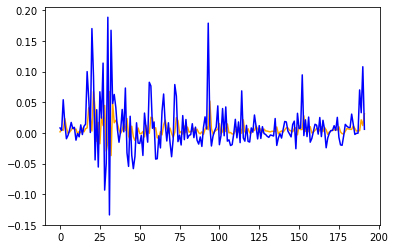

In [60]:
arima_residual = evaluate_arima_model(divi_for_training)
len(arima_residual)

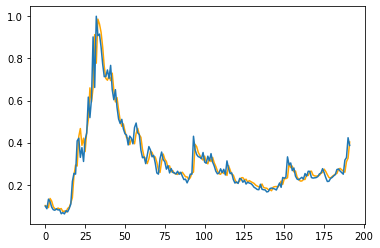

In [49]:
plt.plot(arima_residual+predicted_values, color='orange')
plt.plot(test_y_f_arima)

In [61]:
print("without arima MSE: ",mean_squared_error(test_y_f_arima,predicted_values_f_arima))
print("with arima mse", mean_squared_error(test_y_f_arima,arima_residual+predicted_values_f_arima))

without arima MSE:  0.084148444
with arima mse 0.08148560392664685


In [ ]:
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4], [6,6], [7,7], [8,8]])
y = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
tscv = TimeSeriesSplit(max_train_size=None, n_splits=4)
print(tscv)
for train_index, test_index in tscv.split(matrix_vix):
    print("TRAIN:", train_index, "TEST:", test_index) 
    X_train, X_test = matrix_vix[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]